In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import sys
import scipy
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import plotly.express as px
from tqdm import tqdm
from scipy.stats import ranksums
from adjustText import adjust_text
import gseapy as gp
from datetime import datetime
import tifffile
import matplotlib.patheffects as PathEffects
from statsmodels.stats.multitest import multipletests


# INSERT PATH TO OLIVEIRA P3 NAT DATA
p3_nat_path_08 = "/mnt/x/Common/useful_datasets/Oliveira_preprint/S_P3_NAT/binned_outputs/square_008um/"

paper_path = "/mnt/x/Common/Lab_Papers/shedding_potential/"
fig_path = paper_path + "fig4/"
utils_path = paper_path + "utils/"

os.chdir(utils_path)
print(os.getcwd())
import shed_funcs
from plot_gsea import plot_GSEA
import plot_gsea

import importlib

LOAD_ARIAL = True
if LOAD_ARIAL:
    # set the default font to Arial
    from matplotlib.font_manager import FontProperties, fontManager
    from matplotlib import rcParams
    # Path to Arial font
    arial_path = utils_path+'/Arial.ttf'

    # Define font properties with the specific path
    arial_font = FontProperties(fname=arial_path)
    fontManager.addfont(arial_path)

    # Set the font as the default for all text elements
    rcParams['font.family'] = arial_font.get_family()
    rcParams['font.sans-serif'] = [arial_font.get_name()]

/mnt/x/Common/Lab_Papers/shedding_potential/utils


## Load Stav data

In [2]:
UMI_THRESH = 10000

stav_adata = sc.read_h5ad(fig_path + "dan_et_al_raw_anndata.h5ad")
stav_adata.obs['sample_type'] = stav_adata.obs.sample_type.str.lower().astype(str)

print(stav_adata.shape)
specific_genes_to_remove = ["MTRNR2L12", "MTRNR2L1", "MTRNR2L8"]
filter_genes = stav_adata.var_names.str.startswith("MT-") + stav_adata.var_names.isin(specific_genes_to_remove) + stav_adata.var_names.str.contains("RPL") + stav_adata.var_names.str.contains("RPS")
stav_adata = stav_adata[:,~filter_genes]
print(stav_adata.shape)

# keep protein coding genes
biomart_tbl = pd.read_csv(utils_path + 'Human_GRch38_91_ensemblBioMart_ref.csv')
biomart_tbl_pc = biomart_tbl[(biomart_tbl['gene_biotype'] == "protein_coding")]
stav_adata = stav_adata[:,stav_adata.var_names.isin(biomart_tbl_pc['external_gene_name'])].copy()
print(stav_adata.shape)

stav_adata.var["mt"] = stav_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(stav_adata, qc_vars=['mt'], inplace=True)

# filter samples with less than 10000 UMIs
print(stav_adata.shape)
stav_adata = stav_adata[stav_adata.obs.total_counts > UMI_THRESH,:]
print(stav_adata.shape)

stav_adata.obs['log10_total_counts'] = np.log10(stav_adata.obs['total_counts'])
stav_adata.layers['counts'] = stav_adata.X.copy()
stav_adata.layers['mat_norm'] = sc.pp.normalize_total(stav_adata, target_sum=1, inplace=False,exclude_highly_expressed=True, max_fraction=0.1)['X']

stav_adata

(266, 60591)
(266, 59066)
(266, 19096)
(266, 19096)
(232, 19096)


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/preprocessing/_qc.py:422: RuntimeWarning: invalid value encountered in divide
  return values / sums[:, None]
/tmp/ipykernel_4020787/1028310086.py:26: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  stav_adata.obs['log10_total_counts'] = np.log10(stav_adata.obs['total_counts'])


AnnData object with n_obs × n_vars = 232 × 19096
    obs: 'sample_name', 'rt_barcode', 'pool', 'i7', 'i7_barcode', 'sample_type', 'location', 'patient', 'gender', 'year_of_birth', 'disease', 'year_of_diagnosis', 'weight', 'smoking', 'intestinal_resection', 'concomitant_illnesses', 'disease_location', 'concomitant_biological_therapy', 'concomitant_immunomodulator_therapy', 'concomitant_5asa_therapy', 'concomitant_steroids', 'endoscopic_inflammation', 'histological_inflammation', 'run', 'disease_str', 'inf_type', 'sum_of_umis', 'log10_sum_of_umis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'log10_total_counts'
    var: 'gene_name', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 

(92, 19096)
Correlation: 0.7453015421054213, p-value: 0.0


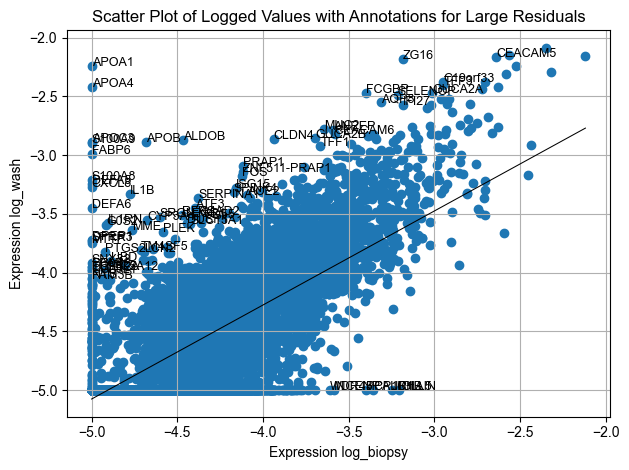

In [3]:
importlib.reload(shed_funcs)

# select controls and RL colon
sdata_hc = stav_adata[(stav_adata.obs.disease_str == "control") * (stav_adata.obs.location.isin(["R","L"]))].copy()
print(sdata_hc.shape)

resids_hc = shed_funcs.calc_resids_by_field(sdata_hc, "sample_type", "biopsy", "wash", RESID_THRESH=1, layer='mat_norm')
resids_hc['gene_display'] = resids_hc.index

In [4]:
# fig = px.scatter(resids_hc, x="log_biopsy", y="log_wash", hover_name='gene_display',
#                   color="residual", title="Biopsy vs Wash residuals in healthy controls")
# fig.show()

In [5]:
# # reload shed_funcs
# importlib.reload(shed_funcs)

# shed_funcs.plot_tissue_shed_for_fig(resids_hc, ["FABP1","GUCA2B","ZG16","ISG15","AQP8","COL1A1",
#                                                 "DUOX2","SLC17A4","SLC26A2","SLC22A5","JCHAIN"],
#                                     fontsize=8,figsize=(3,3),spot_size=2, add_arrows=False, reg_line_width=0.75,
#                                     my_xlabel="Colon biopsy", my_ylabel="Colon wash", use_adjust_text=False, white_outline_width=0,
#                                     exp_path=fig_path+"Fig4a_colon_biopsy_wash.pdf")

## Annotations

In [6]:
ELSE_STR = "else"
LP_STR = "lp"
CRYPT_STR = "crypt_epi"
INTER_CRYPT_STR = "inter_crypt_epi"
MUSCLE_STR = "muscle"
TISSUE_STR = "Tissue"
EPITHEIUM_STR = "Epithelium"

nat3_annotation_dict = dict({"muscle":MUSCLE_STR, "Epithelium":EPITHEIUM_STR, "Tissue":TISSUE_STR,
                              "Lamina_Propria":LP_STR, LP_STR:LP_STR, "intercrypt":INTER_CRYPT_STR})

### Load Loupe Browser KNN=6
- Cluster 1: Submucosa stroma
- Cluster 2: Submucosa stroma 2
- Cluster 3: Muscle
- Cluster 4: Lamina propria
- Cluster 5: Crypt-Epithelium
- Cluster 6: Inter-crypt epithelium

In [7]:
knn_path = fig_path+"/K-Means 6.csv"
knn_df = pd.read_csv(knn_path)

knn_dict = {"Cluster 4":LP_STR, "Cluster 5":CRYPT_STR, "Cluster 6":INTER_CRYPT_STR}

knn_df.index = knn_df['Barcode']
knn_df.rename(columns={"6":"cluster"}, inplace=True)
knn_df['cluster_name'] = knn_df['cluster'].map(knn_dict)
knn_df.head()

Barcode    cluster cluster_name
Barcode                                                             
s_008um_00301_00321-1  s_008um_00301_00321-1  Cluster 2          NaN
s_008um_00602_00290-1  s_008um_00602_00290-1  Cluster 2          NaN
s_008um_00425_00829-1  s_008um_00425_00829-1  Cluster 3          NaN
s_008um_00526_00291-1  s_008um_00526_00291-1  Cluster 4           lp
s_008um_00681_00396-1  s_008um_00681_00396-1  Cluster 1          NaN

### Select annoation method

In [8]:
print("Using KNN (n=6) clustering")
clustering_df = knn_df

lp_spots = clustering_df.loc[clustering_df['cluster_name'] == LP_STR].Barcode.values
crypt_epi_spots = clustering_df.loc[clustering_df['cluster_name'] == CRYPT_STR].Barcode.values
inter_crypt_epi_spots = clustering_df.loc[clustering_df['cluster_name'] ==INTER_CRYPT_STR].Barcode.values

Using KNN (n=6) clustering


## Load Olivera's VisiumHD data

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


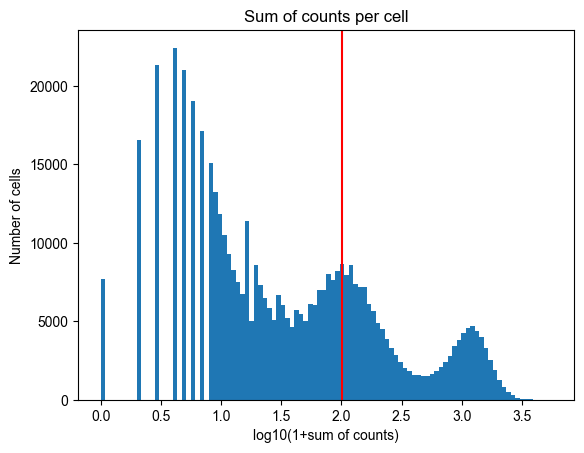

before UMI Thresh: (487552, 18085)
After UMI Thresh of 100: (136371, 18085)


In [9]:
UMI_THRESH = 100

tissue_positions = pd.read_parquet(p3_nat_path_08+"spatial/tissue_positions.parquet")
tissue_positions.index = tissue_positions.barcode

p3_nat = sc.read_10x_h5(p3_nat_path_08+"filtered_feature_bc_matrix.h5")
p3_nat.var_names_make_unique()

p3_nat = p3_nat[np.intersect1d(tissue_positions.barcode, p3_nat.obs_names)]
p3_nat.obs = tissue_positions.loc[p3_nat.obs_names]

# add layers
p3_nat.layers['counts'] = p3_nat.X.copy()

p3_nat.obs['sum_of_umis'] = p3_nat.layers['counts'].sum(axis=1)
plt.hist(np.log10(1+p3_nat.obs['sum_of_umis']), bins=100)
# add line at UMI_THRESH
plt.axvline(np.log10(1+UMI_THRESH), color='red')
plt.xlabel("log10(1+sum of counts)")
plt.ylabel("Number of cells")
plt.title("Sum of counts per cell")
plt.show()

# filter cells with too few counts
print(f"before UMI Thresh: {p3_nat.shape}")
p3_nat = p3_nat[p3_nat.obs['sum_of_umis'] > UMI_THRESH].copy()
print(f"After UMI Thresh of {UMI_THRESH}: {p3_nat.shape}")

sc.pp.normalize_total(p3_nat, target_sum=1)
p3_nat.layers['mat_norm'] = p3_nat.X.copy()
sc.pp.normalize_total(p3_nat, target_sum=1e4)
sc.pp.log1p(p3_nat)
p3_nat.layers['log1p_norm'] = p3_nat.X.copy()

In [10]:
# map clustering to p3_nat
p3_nat.obs['cluster_name'] = p3_nat.obs.barcode
p3_nat.obs.cluster_name = p3_nat.obs.cluster_name.map(clustering_df['cluster_name'])

### Add turnover score to Oliviera's data

In [11]:
# add turnover score
print(resids_hc.shape)
intersect_genes = np.intersect1d(resids_hc.index, p3_nat.var_names)
shedding_resids = resids_hc.loc[intersect_genes]
print(resids_hc.shape)

p3_nat.obs['shedding_score'] = None
p3_nat.var['shedding_residual'] = None
p3_nat.var.loc[shedding_resids.index, 'shedding_residual']= shedding_resids['residual']

tmp_ad = p3_nat[:,shedding_resids.index].copy()
sc.pp.normalize_total(tmp_ad, target_sum=1, exclude_highly_expressed=True, max_fraction=0.1)

print(tmp_ad.shape)

resids_vals = np.array(tmp_ad.var['shedding_residual'])
resids_vals = np.expand_dims(resids_vals, axis=1).ravel()
resids_matnorm = tmp_ad.layers['mat_norm']

shedding_scores = resids_matnorm @ resids_vals.astype(float)

tmp_ad.obs['shedding_score'] = np.squeeze(np.array(shedding_scores))
# send back the shedding score from the tmp_ad to the adata
p3_nat.obs.loc[tmp_ad.obs.index, 'shedding_score'] = tmp_ad.obs.loc[tmp_ad.obs.index, 'shedding_score']


(19096, 6)
(19096, 6)


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


(136371, 17598)


In [12]:
# create loupe file with shedding quantiles within intercrypt
N_quantiles = 10
quantiles = pd.qcut(p3_nat.obs.shedding_score.astype(float), N_quantiles, labels=False)
p3_nat.obs['shedding_quantile'] = quantiles
p3_nat.obs[['barcode','shedding_quantile']].to_csv(fig_path+"/p3_nat_shedding_quantiles.csv",index=False,header=True)

In [13]:
# create csv file with shedding scores
p3_nat.obs[['barcode','shedding_score']].to_csv(fig_path+"/p3_nat_shedding_scores.csv",index=False,header=True)

In [14]:
p3_nat.uns = dict(pd.read_json(p3_nat_path_08+"spatial/scalefactors_json.json", typ="series"))
p3_nat.uns

{'spot_diameter_fullres': 29.22194247540292,
 'bin_size_um': 8.0,
 'microns_per_pixel': 0.27376687934875804,
 'regist_target_img_scalef': 0.0744768,
 'tissue_lowres_scalef': 0.00744768,
 'fiducial_diameter_fullres': 1205.4051271103706,
 'tissue_hires_scalef': 0.0744768}

In [15]:
# # Plot the fullres image - it takes a while

# fullres_path = "/mnt/x/Common/useful_datasets/Oliveira_preprint/S_P3_NAT/Visium_HD_Human_Colon_Normal_P3_tissue_image_CROPPED2.tif"
# # read tif file
# fullres_img = tifffile.imread(fullres_path)

# # fullres_img = plt.imread(fullres_path)
# plt.imshow(fullres_img)
# # reverse Y axies
# plt.gca().invert_yaxis()
# plt.show()

### Load manual annotations

In [16]:
# import annotations
# annotations_path = fig_path+"Visium_HD_Human_Colon_Normal_P3_tissue_image_Tal_annotations.geojson"
annotations_path = fig_path+"Visium_HD_Human_Colon_Normal_P3_tissue_image_CROPPED2.geojson"

nat3_gdf = gpd.read_file(annotations_path)

# add tissue type to the geodataframe
nat3_gdf['pixel_type_annotation']=[my_type.split('"')[3] for my_type in nat3_gdf['classification']]

tissue_gdf = nat3_gdf[nat3_gdf['pixel_type_annotation'].isin([TISSUE_STR])] # focus on the mucosa layer
tissue_gdf

id  objectType  \
304  144c967d-83df-4aa6-864b-1cdf26227c3f  annotation   
305  f74165c3-3d76-4322-8bda-fc53cd1d8bee  annotation   

                                     classification  \
304  { "name": "Tissue", "color": [ 0, 255, 255 ] }   
305  { "name": "Tissue", "color": [ 0, 255, 255 ] }   

                                              geometry pixel_type_annotation  
304  POLYGON ((4717.57 14493.23, 4723 14484, 4727.9...                Tissue  
305  POLYGON ((7314.24 32520.75, 7312 32520, 7309 3...                Tissue

In [17]:
my_xlim = (500, 2000)
my_ylim = (25000, 26550)

In [18]:
nat3_gdf_tissue_only = nat3_gdf[nat3_gdf['pixel_type_annotation'].isin([TISSUE_STR])]

In [19]:
tmp_obs_tissue = gpd.GeoDataFrame(p3_nat.obs, geometry=gpd.points_from_xy(p3_nat.obs["pxl_col_in_fullres"],p3_nat.obs['pxl_row_in_fullres']))
merged_obs_tissue = gpd.sjoin(tmp_obs_tissue, nat3_gdf_tissue_only, how='left', predicate='intersects') # predicate can be within
merged_obs_tissue = merged_obs_tissue[~merged_obs_tissue.index.duplicated(keep="first")]
merged_obs_tissue = merged_obs_tissue[~merged_obs_tissue['id'].isna()]

/tmp/ipykernel_4020787/1452147736.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_obs_tissue = gpd.sjoin(tmp_obs_tissue, nat3_gdf_tissue_only, how='left', predicate='intersects') # predicate can be within


In [20]:
# Keep only the intersect between the tissue (mucosa) and the rest
tmp_obs = gpd.GeoDataFrame(p3_nat.obs, geometry=gpd.points_from_xy(p3_nat.obs["pxl_col_in_fullres"],p3_nat.obs['pxl_row_in_fullres']))

merged_obs = gpd.sjoin(tmp_obs, nat3_gdf_tissue_only, how='left', predicate='within')
merged_obs = merged_obs[~merged_obs.index.duplicated(keep="first")]
# remove rows with nan id
merged_obs = merged_obs[~merged_obs['id'].isna()]

# select the intersect between the tissue and the rest
merged_obs = merged_obs.loc[np.intersect1d(merged_obs.index, merged_obs_tissue.index)]

# create anndata with annotated pixels
gdata = p3_nat[merged_obs.index]
gdata.obs = merged_obs

/tmp/ipykernel_4020787/1284902320.py:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  merged_obs = gpd.sjoin(tmp_obs, nat3_gdf_tissue_only, how='left', predicate='within')


In [21]:
combined_spots_list = np.intersect1d(gdata.obs_names, np.concatenate([lp_spots, crypt_epi_spots, inter_crypt_epi_spots])).tolist()

In [22]:
# add classification class to the gdata
gdata.obs['pixel_type_clustering'] = ELSE_STR
gdata.obs.loc[np.intersect1d(gdata.obs_names, lp_spots), 'pixel_type_clustering'] = LP_STR
gdata.obs.loc[np.intersect1d(gdata.obs_names, crypt_epi_spots), 'pixel_type_clustering'] = CRYPT_STR
gdata.obs.loc[np.intersect1d(gdata.obs_names, inter_crypt_epi_spots), 'pixel_type_clustering'] = INTER_CRYPT_STR

In [23]:
intercrypt_gdata = gdata[gdata.obs[(gdata.obs.pixel_type_clustering == INTER_CRYPT_STR)].index]
intercrypt_gdata.var['gene_name'] = intercrypt_gdata.var.index

/tmp/ipykernel_4020787/4099937411.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  intercrypt_gdata.var['gene_name'] = intercrypt_gdata.var.index


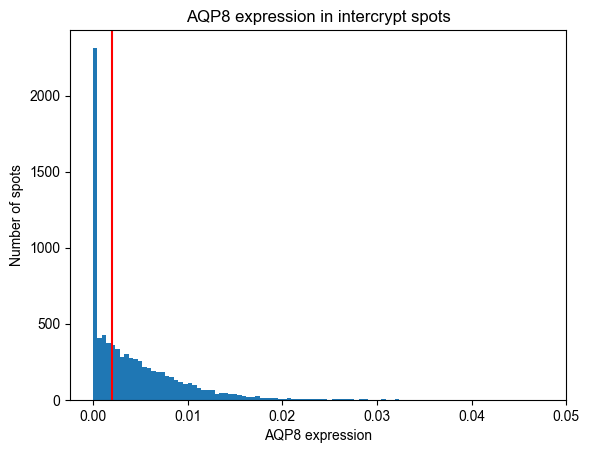

In [24]:
USE_AQP8_FITERING = True

if USE_AQP8_FITERING:
    # refine intercrypt spots by AQP8 expression
    AQP_THRESH = 2e-3
    # hist AQP8 expression
    plt.hist(intercrypt_gdata[:, "AQP8"].layers['mat_norm'].todense(), bins=100)
    plt.axvline(AQP_THRESH, color='red')
    plt.xlabel("AQP8 expression")
    plt.ylabel("Number of spots")
    plt.title("AQP8 expression in intercrypt spots")
    plt.show()
    intercrypt_gdata = intercrypt_gdata[intercrypt_gdata[:,"AQP8"].layers['mat_norm'] > AQP_THRESH]

In [27]:
# export quantiles of intercrypt enterocytes
N_quantiles = 10
quantiles = pd.qcut(gdata[gdata.obs.pixel_type_clustering == INTER_CRYPT_STR].obs.shedding_score.astype(float), N_quantiles, labels=False)
pd.DataFrame(quantiles).rename(columns={'shedding_score':'shedding_quantile_intercrypt'}).rename_axis("barcode").to_csv(fig_path+"/p3_nat_shedding_quantiles_intercrypt.csv",index=True,header=True)

# export quantiles of all tissue
N_quantiles = 10
quantiles = pd.qcut(p3_nat.obs.shedding_score.astype(float), N_quantiles, labels=False)
pd.DataFrame(quantiles).rename(columns={'shedding_score':'shedding_quantile'}).rename_axis("barcode").to_csv(fig_path+"/p3_nat_shedding_quantiles.csv",index=True,header=True)

inter_crypt_epi
lp
crypt_epi
else


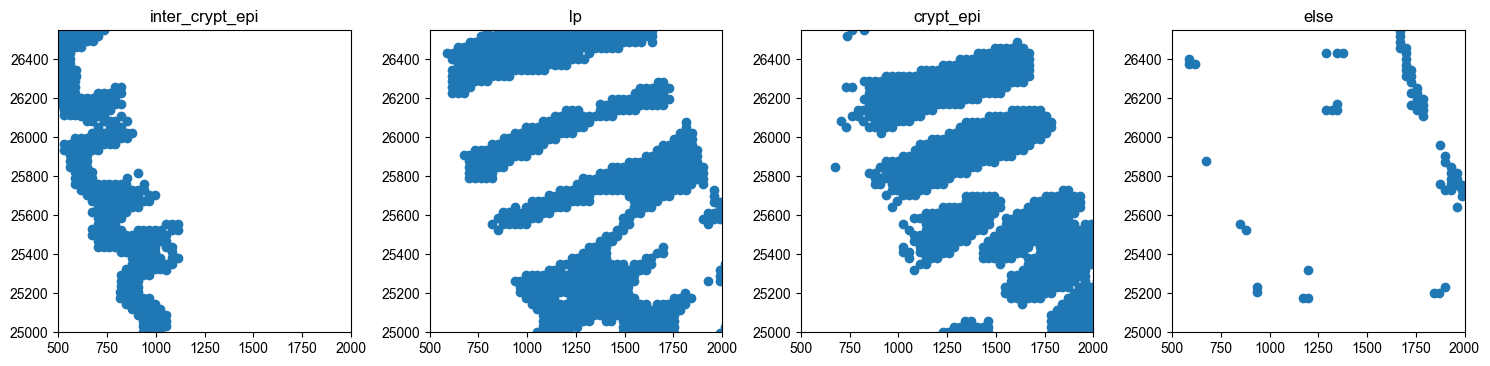

In [28]:
# plot each component of the tissue
USE_FIELD = 'pixel_type_clustering'#'pixel_type_annotation'#'pixel_type_clustering'
unique_types = gdata.obs[USE_FIELD].unique()

fig, axes = plt.subplots(nrows=1, ncols=len(unique_types), figsize=(15, 5))
for ax, my_type in zip(axes, unique_types):
    print(my_type)
    # tmp = gdata.obs.loc[(gdata.obs[USE_FIELD] == my_type)*(gdata.obs["annotation_consensus"]), :]
    tmp = gdata.obs.loc[(gdata.obs[USE_FIELD] == my_type), :]
    tmp['geometry'].plot(ax=ax, aspect=1)
    ax.set_title(my_type)
    ax.set_xlim(my_xlim)
    ax.set_ylim(my_ylim)

plt.tight_layout()
plt.show()

In [29]:
# find distance between pixels
dists = squareform(pdist(gdata.obs[['pxl_row_in_fullres', 'pxl_col_in_fullres']]))

In [30]:
USE_ADJUST_TEXT = False
white_outline_width = 0
SCATTER_POINT_SIZE = 5
FONT_SIZE = 6
my_edge_color = "#a3a3a3"

/mnt/x/Common/Lab_Papers/shedding_potential/utils/shed_funcs.py:253: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  dge_intercrypt.obs['shedding_score_cat'] = 'intermediate'


shedding_score_cat
high    1507
low     1507
Name: count, dtype: int64


/mnt/x/Common/Lab_Papers/shedding_potential/utils/shed_funcs.py:331: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


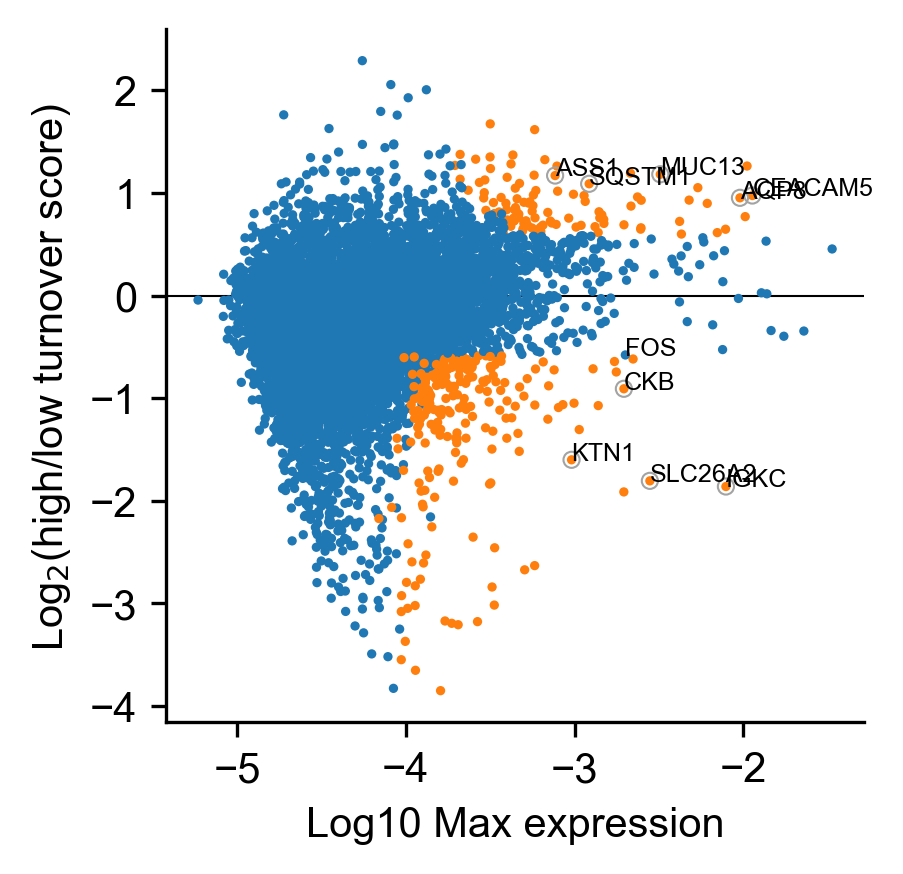

In [31]:
SHEDDING_EDGE = 33
EXP_THRESH = 1e-5
PN = 5e-6
Q_THRESH = 0.05
FC_THRESH = 1.5
USE_ADJUST_TEXT = False

df_intercrypt = shed_funcs.dge_high_low_shed(intercrypt_gdata, SHEDDING_EDGE=SHEDDING_EDGE, EXP_THRESH=EXP_THRESH,PN=PN, Q_THRESH=Q_THRESH, FC_THRESH=FC_THRESH)
ma_fig = shed_funcs.ma_plot_shedding(df_intercrypt, additional_N_genes = 0, 
                                     add_genes = ["ASS1","SQSTM1","AQP8","CEACAM5","IGKC","MUC13","CKB","SLC26A2","FOS","KTN1"], font_size=6)
# ma_fig.savefig(fig_path+"fig4d_high_VS_low_shedding_Oliviera.pdf", )

In [32]:
px.scatter(df_intercrypt, x='log10_max', y='log2fc', color='significant', hover_name='gene_name', hover_data=['pvals_adj'])

Spearman correlation: 0.4915943961744955, p-value: 0.0
<1e-323


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/matplotlib/text.py:757: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/matplotlib/text.py:758: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/matplotlib/text.py:897: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/matplotlib/text.py:898: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



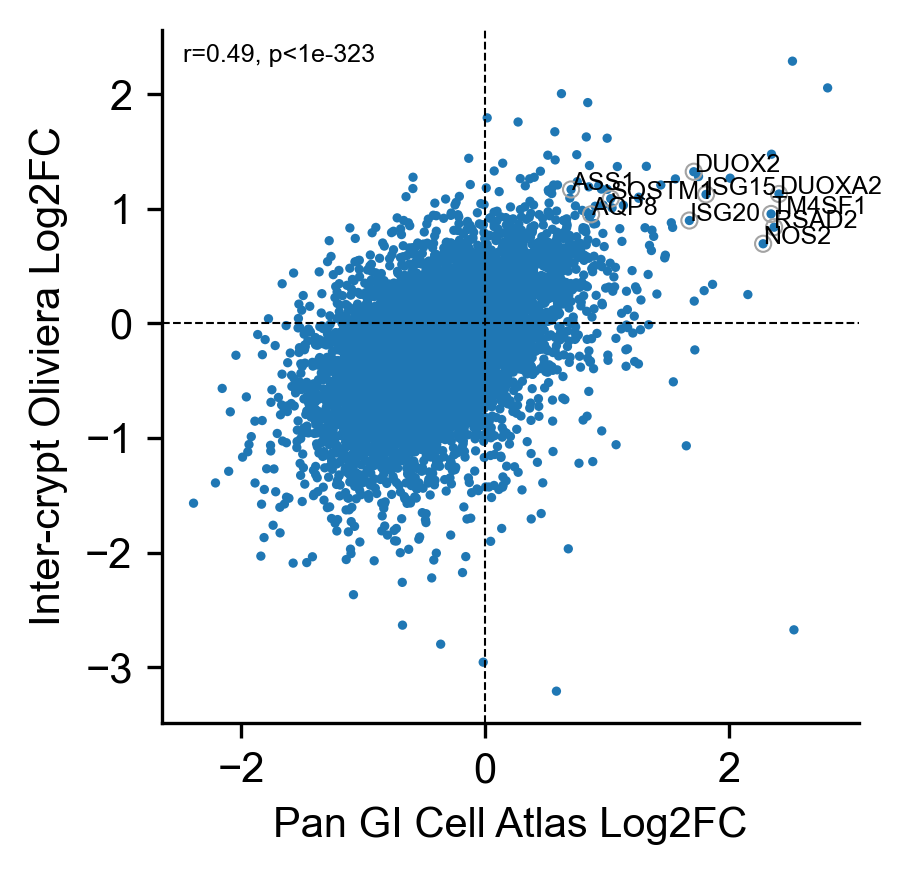

In [33]:
SCATTER_POINT_SIZE = 5
FONT_SIZE = 6
my_edge_color = "#a3a3a3"

# read HGCA high/low results
dge_hgca = pd.read_csv(fig_path+"HGCA_dge_high_low_shed.csv", index_col=0)
intersected_genes = np.intersect1d(df_intercrypt.gene_name, dge_hgca.index)
hgca_l2fc = dge_hgca.loc[intersected_genes].log2fc
hgca_significance = dge_hgca.loc[intersected_genes].significant
intercrypt_l2fc = df_intercrypt.loc[intersected_genes].log2fc

# calculatea the spearman correlation
[r,p] = scipy.stats.spearmanr(hgca_l2fc, intercrypt_l2fc)
print(f"Spearman correlation: {r}, p-value: {p}")

fig, ax = plt.subplots(figsize=(3,3), dpi=300)
sns.scatterplot(x=hgca_l2fc,y=intercrypt_l2fc,ax=ax, edgecolor="none", s=SCATTER_POINT_SIZE)

# show specific genes
texts = ["NOS2","ASS1","SQSTM1","AQP8","DUOXA2","DUOX2","ISG15","TM4SF1","ISG20","RSAD2"]
sns.scatterplot(x=hgca_l2fc[texts], y=intercrypt_l2fc[texts], edgecolor=my_edge_color, linewidth=0.5, s=SCATTER_POINT_SIZE*3, facecolor="none", ax=ax)

for text in texts:
    x = hgca_l2fc[intersected_genes == text]
    y = intercrypt_l2fc[intersected_genes == text]
    ax.text(x, y, text, size=6)

# despine top and right
ax.spines[['right', 'top']].set_visible(False)

# add text to top left quadrant: r+p
if p > 0:
    ax.text(0.03, 0.98, f"r={r:.2f}, p={p:.2e}", transform=ax.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left')
else:
    for ii in range(1000):
        if 10**-ii == 0:
            p="<1e-"+str(ii-1)
            print(p)
            break
    ax.text(0.03, 0.98, f"r={r:.2f}, p{p}", transform=ax.transAxes, fontsize=6, verticalalignment='top', horizontalalignment='left')

# add x=0 and y=0 lines
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.xlabel("Pan GI Cell Atlas Log2FC")
plt.ylabel("Inter-crypt Oliviera Log2FC")
plt.show()
fig.savefig(fig_path+"Fig5b_PanGIvs_intercrypt.pdf")

px.scatter(x=hgca_l2fc,y=intercrypt_l2fc, hover_name=intersected_genes)



In [34]:
# get gsea gene sets
gene_sets = gp.get_library_name()
# find gene sets that contians MSigDB
gene_sets = [x for x in gene_sets if 'MSigDB' in x]
gene_sets

['MSigDB_Computational', 'MSigDB_Hallmark_2020', 'MSigDB_Oncogenic_Signatures']

2025-02-18 08:54:09,946 [WARNING] Duplicated values found in preranked stats: 5.61% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Q-value thresh: 0.2


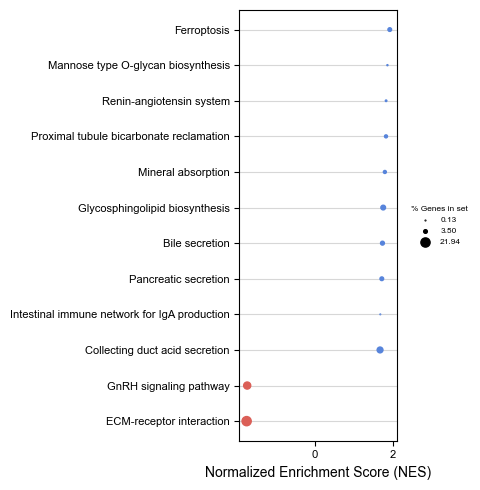

In [35]:
Q_THRESH = 0.2
prerank_df = df_intercrypt[['gene_name','score']]
prerank_df.set_index('gene_name', inplace=True)
prerank_df.index = prerank_df.index.str.upper()

selected_gene_set = "KEGG_2021_Human" # MSigDB_Hallmark_2020
pre_res = gp.prerank(rnk = prerank_df,
                     gene_sets=selected_gene_set,threads=4, min_size=5,max_size=1000,
                     permutation_num=1000, outdir=None, seed=6,verbose=False)

importlib.reload(plot_gsea)
if pre_res.res2d['FDR q-val'].min() < Q_THRESH:
    _ = plot_gsea.plot_GSEA(pre_res.res2d, qval_thresh=Q_THRESH)
else:
    print("No significant gene sets")

## Examine LP adjacent to high shedding score spots

In [36]:
gg = "shedding_score"
my_layer='mat_norm'
percent_to_take = 2

# identify the top X% of cells expressing the gene
intercrypt_epi_mask = gdata.obs['pixel_type_clustering'].isin(['inter_crypt_epi']) # IGNOTE CRYPT EPI - to control for LP zonal variability

top_val = np.percentile(gdata[intercrypt_epi_mask].obs.shedding_score, 100-percent_to_take)
top_pixels = gdata[intercrypt_epi_mask].obs[gdata[intercrypt_epi_mask].obs.shedding_score >= top_val].index
print(f"Top {percent_to_take}% of epithelial pixels expressing {gg}: {len(top_pixels)}")

# bot_val = np.percentile(gdata[intercrypt_epi_mask].obs.shedding_score, percent_to_take)
# bot_pixels = gdata[intercrypt_epi_mask].obs[gdata[intercrypt_epi_mask].obs.shedding_score <= bot_val].index
# print(f"Bottom {percent_to_take}% of epithelial pixels expressing {gg}: {len(bot_pixels)}")

lp_pixels = gdata.obs[gdata.obs['pixel_type_clustering'] == LP_STR].index

Top 2% of epithelial pixels expressing shedding_score: 163


In [37]:
# identify the upper/luminal LP pixels (closest to the inter-crypt-epi pixels)
inter_crypt_epi_idx = np.where(gdata.obs['pixel_type_clustering'] == INTER_CRYPT_STR)[0]
gdata.obs['lp_close_to_inter_crypt_epi'] = False
DIST_THRESH = 70

for my_idx, my_pixel in zip(inter_crypt_epi_idx, gdata[gdata.obs['pixel_type_clustering'] == INTER_CRYPT_STR].obs_names):
    my_dists_um = dists[my_idx, :]*gdata.uns['microns_per_pixel']
    
    # find the LP pixels within 70um
    close_idx = np.where(my_dists_um <= DIST_THRESH)[0]
    close_bc = gdata.obs.index[close_idx]
    close_bc = close_bc[~close_bc.isin([my_pixel])] # exclude the pixel itself

    # select only the LP pixels
    close_bc = close_bc[close_bc.isin(lp_pixels)]
    
    # assign the LP pixels to the close_to column
    gdata.obs.loc[close_bc, 'lp_close_to_inter_crypt_epi'] = True

In [38]:
# find the numerical index of the top pixels
top_idx = np.where(gdata.obs.index.isin(top_pixels))[0]
gdata.obs['close_to'] = 'none'

for my_idx, my_pixel in zip(top_idx, top_pixels):
    # find the distance to each LP pixel
    my_dists_um = dists[my_idx, :]*gdata.uns['microns_per_pixel']
    # find the LP pixels within 50um
    close_idx = np.where(my_dists_um <= DIST_THRESH)[0]
    close_bc = gdata.obs.index[close_idx]
    close_bc = close_bc[~close_bc.isin([my_pixel])] # exclude the pixel itself

    # select only the LP pixels
    close_bc = close_bc[close_bc.isin(lp_pixels)]
    # assign the LP pixels to the close_to column
    gdata.obs.loc[close_bc, 'close_to'] = 'top'

    # set lp_close_to_inter_crypt_epi to False
    # gdata.obs.loc[close_bc, 'lp_close_to_inter_crypt_epi'] = False

/tmp/ipykernel_4020787/2933563011.py:41: UserWarning:

FixedFormatter should only be used together with FixedLocator

/tmp/ipykernel_4020787/2933563011.py:42: UserWarning:

FixedFormatter should only be used together with FixedLocator



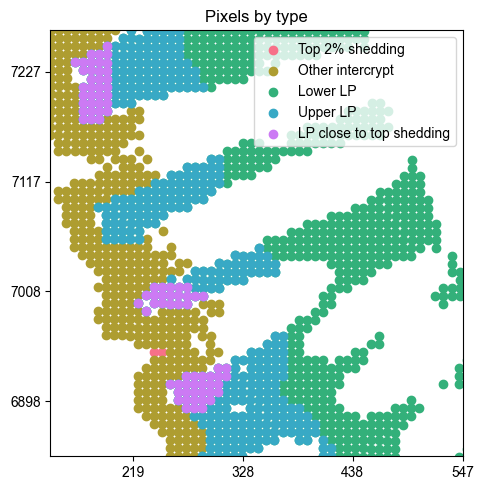

In [39]:
# valiadte that the pixels are assigned correctly

# identify cells of interest and explore neighbouring LP pixels within specific range 50um
# epi_other = np.setdiff1d(gdata[intercrypt_epi_mask].obs.index, np.union1d(top_pixels, bot_pixels))
epi_other = np.setdiff1d(gdata[intercrypt_epi_mask].obs.index, top_pixels)

# plot the pixels on the image
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
my_pallette = sns.color_palette("husl", 5) # it was 6
    
tmp = gdata.obs.loc[top_pixels, :]
tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[0])

# tmp = gdata.obs.loc[bot_pixels, :]
# tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[1])

tmp = gdata.obs.loc[epi_other, :]
tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[1])

tmp = gdata.obs.loc[lp_pixels, :]
tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[2])

tmp = gdata.obs.loc[gdata.obs.lp_close_to_inter_crypt_epi, :]
tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[3])

tmp = gdata.obs.loc[gdata.obs.close_to=="top", :]
tmp['geometry'].plot(ax=ax, aspect=1, color=my_pallette[4])

ax.set_xlim(my_xlim)
ax.set_ylim(my_ylim)
ax.set_title("Pixels by type")

# set x and y ticks to 4 per axis
N_TICKS = 4
ax.xaxis.set_major_locator(plt.MaxNLocator(N_TICKS))
ax.yaxis.set_major_locator(plt.MaxNLocator(N_TICKS))

# convert the ticks to microns
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()
ax.set_xticklabels([f"{int(x)}" for x in x_ticks*gdata.uns['microns_per_pixel']])
ax.set_yticklabels([f"{int(y)}" for y in y_ticks*gdata.uns['microns_per_pixel']])
# add x and y labels
# ax.set_xlabel("microns")
# ax.set_ylabel("microns")

#add legend
ax.legend(['Top {}% shedding'.format(percent_to_take),# 'Bottom {}% shedding'.format(percent_to_take), 
           "Other intercrypt","Lower LP","Upper LP",'LP close to top shedding'], loc='upper right')
plt.tight_layout()
plt.show()

In [40]:
EXP_THRESH = 1e-5
# PN = 1e-5
PN = 5e-6
Q_THRESH = 0.05

print("EXP THRESH: " + str(EXP_THRESH))
print("PN: " + str(PN))
print("Q_THRESH: " + str(Q_THRESH))
print("FC_THRESH: " + str(FC_THRESH))
 
lp_close_to_top_bc = gdata[(gdata.obs.lp_close_to_inter_crypt_epi)*(gdata.obs['close_to'] == 'top')].obs_names
lp_other_bc = gdata[(gdata.obs.lp_close_to_inter_crypt_epi)*(gdata.obs.close_to == "none")].obs_names

dge_lp = gdata[list(lp_close_to_top_bc)+list(lp_other_bc)].copy()
dge_lp = dge_lp[:,np.ravel(dge_lp.layers['mat_norm'].mean(axis=0)) > EXP_THRESH]

sc.tl.rank_genes_groups(dge_lp, groupby='close_to', method='wilcoxon', use_layer='log1p_norm')
dedf_lp = sc.get.rank_genes_groups_df(dge_lp, group='top')
dedf_lp['gene_name'] = dedf_lp['names']
dedf_lp.set_index('names', inplace=True)
m_high_spots = pd.Series(np.ravel(dge_lp[dge_lp.obs['close_to'] == 'top'].layers['mat_norm'].mean(axis=0)), index=dge_lp.var_names)
m_low_spots = pd.Series(np.ravel(dge_lp[dge_lp.obs['close_to'] == 'none'].layers['mat_norm'].mean(axis=0)), index=dge_lp.var_names)
dedf_lp['m_high'] = m_high_spots
dedf_lp['m_low'] = m_low_spots
dedf_lp['log2fc'] = np.log2((PN + dedf_lp['m_high']) / (PN + dedf_lp['m_low']))
dedf_lp['max'] = np.max([m_high_spots, m_low_spots],axis=0)
dedf_lp['log10_max'] = np.log10(dedf_lp['max'])

df_lp = pd.DataFrame({'gene_name':dge_lp.var_names,
                            'm_high': m_high_spots,
                            'm_low': m_low_spots,
                            'log10_max': np.log10(np.ravel(np.max([m_high_spots, m_low_spots],axis=0))),
                            'log2fc': np.log2((PN + dedf_lp['m_high']) / (PN + dedf_lp['m_low'])),
                            'pvals':dedf_lp['pvals'],
                            'pvals_adj':dedf_lp['pvals_adj'],
                            'score':dedf_lp['scores']}, 
                            index=dge_lp.var_names)

df_lp.sort_values('score', ascending=False, inplace=True)
df_lp['nlogq'] = -np.log10(df_lp['pvals_adj'])
df_lp['significant'] = (df_lp['pvals_adj'] < Q_THRESH) * (df_lp['log2fc'].abs() > np.log2(FC_THRESH))

EXP THRESH: 1e-05
PN: 5e-06
Q_THRESH: 0.05
FC_THRESH: 1.5


/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/home/talbarka/miniconda3/envs/bilomics_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, 

/mnt/x/Common/Lab_Papers/shedding_potential/utils/shed_funcs.py:331: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



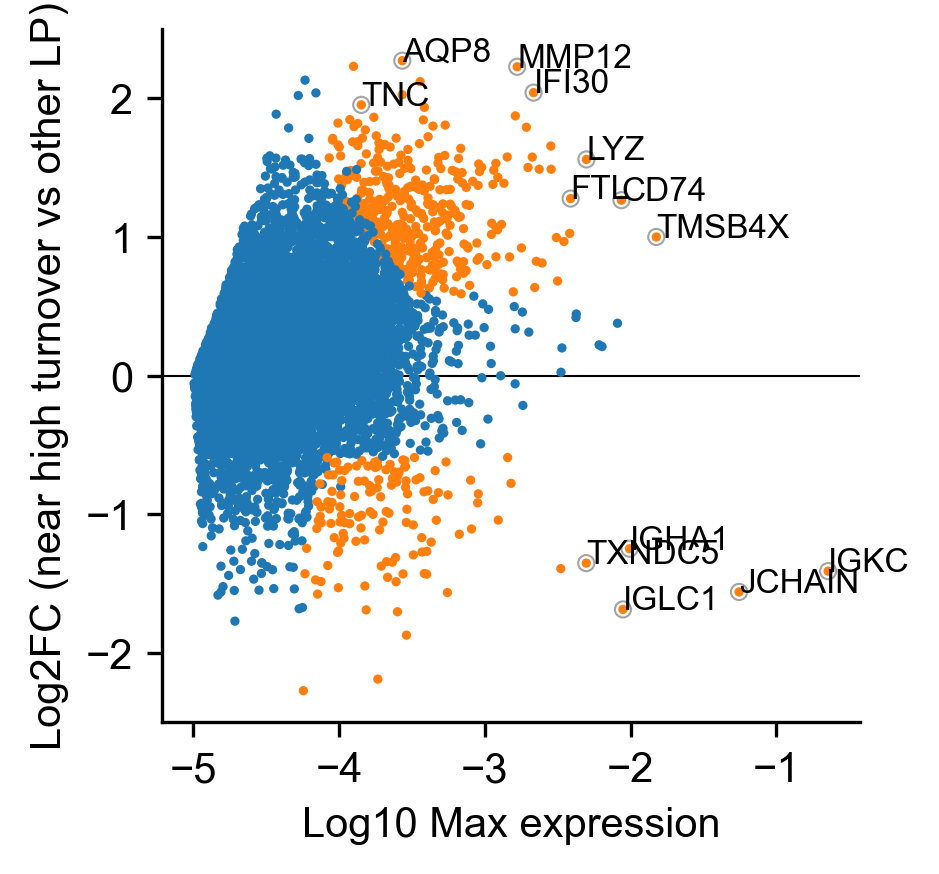

In [41]:
importlib.reload(shed_funcs)
lp_fig = shed_funcs.ma_plot_shedding(df_lp, additional_N_genes = 5, add_genes=["MMP12","TNC","AQP8"],
                                     ylabel="Log2FC (near high turnover vs other LP)")
lp_fig.savefig(fig_path+"fig5f_LP_close_to_top_shedding_Oliviera.pdf")

In [42]:
px.scatter(df_lp, x='log10_max', y='log2fc', color='significant', hover_name='gene_name', hover_data=['pvals_adj'])

In [43]:
# Prepare the data for GSEA prerank analysis
rnk = df_lp[['gene_name', 'score']].copy()
rnk.columns = ['gene', 'score']
rnk = rnk.sort_values(by='score', ascending=False)

selected_gene_set = "KEGG_2021_Human"
# Perform GSEA prerank analysis
pre_res = gp.prerank(rnk = rnk, gene_sets=selected_gene_set,
                     threads=4, min_size=5, max_size=1000, permutation_num=1000, # reduce number to speed up testing
                     outdir=None, seed=6,verbose=False) # see what's going on behind the scenes

2025-02-18 08:55:11,446 [WARNING] Duplicated values found in preranked stats: 0.99% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


Q-value thresh: 0.05


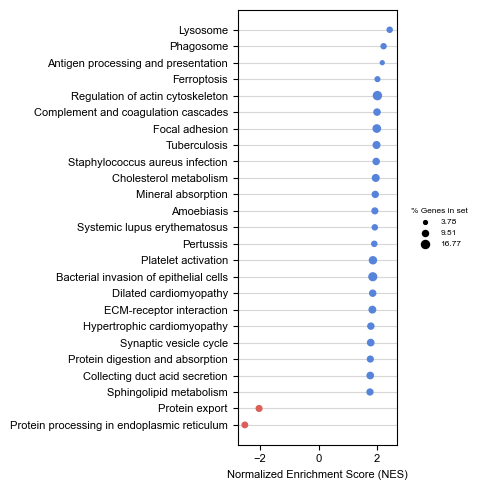

In [44]:
tmp,gsea_fig = plot_GSEA(pre_res.res2d, qval_thresh=0.05, xlabel_fontsize=8, return_figure=True)

In [45]:
gsea_fig.savefig(fig_path+"figSXXX_Oliviera_LP_near_high_shed_VS_other_high_LP_GSEA.pdf", dpi=300)

In [46]:
print(datetime.now())

2025-02-18 08:55:22.486636
